## Maintenance Prédictive - Analyse Exploratoire des Données 

Objective: L’objectif de ce notebook est de mener une analyse exploratoire des données (EDA) afin d’identifier des tendances, 
des anomalies et des relations potentielles au sein du jeu de données.   
Cette étape vise à mieux comprendre la structure des données et à préparer les bases pour 
des modèles prédictifs ou d’autres analyses approfondies.  

Dataset: Predictive maintenance dataset  
URL: https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset 


Le jeu de données se compose de 10 000 points de données stockés sous forme de lignes avec 14 caractéristiques.  

Caractéristiques: 
- UID: identifiant unique allant de 1 à 10 000  
- Product ID: composé d’une lettre L, M ou H indiquant la qualité du produit (Low - basse qualité : 50 % des produits, Medium - moyenne qualité : 30 %, High - haute qualité : 20 %), suivie d’un numéro de série spécifique à la variante
- Air temperature [K]: de données générés avec méthode random walk puis normalisée avec un écart-type de 2 K autour de 300 K
- Process temperature [K]: générée à l’aide d’une méthode random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- Rotational speed [rpm]: calculé à partir d’une puissance de 2860 W, avec un bruit ajouté suivant une distribution normale
- Torque [Nm]: distribution normale autour de 40 Nm avec un écart-type (σ) de 10 Nm, sans valeurs négatives. 
- Tool wear [min]: les variantes de qualité H/M/L ajoutent respectivement 5/3/2 minutes d’usure de l’outil pendant le processus  

Variables cibles:
- Machine Failure: indique panne de machine (si la machine a échoué pour un point de données donné)   
- Tool Wear Failure (TWF): l’outil est remplacé ou tombe en panne à un moment aléatoire d’usure entre 200 et 240 minutes (120 cas dans notre jeu de données). Dans ces cas, l’outil est remplacé 69 fois et tombe en panne 51 fois (choix aléatoire)
- Heat Dissipation Failure (HDF): une panne du processus se produit si la différence entre la température de l’air et celle du processus est inférieure à 8,6 K et que la vitesse de rotation de l’outil est inférieure à 1380 rpm. Ce cas est présent dans 115 points de données.
- Power Failure (PWF): si le produit du couple et de la vitesse de rotation (en rad/s) est inférieur à 3500 W ou supérieur à 9000 W, le processus échoue. Cela concerne 95 points de données dans notre jeu
- Overstrain Failure (OSF):  le processus échoue si le produit de l’usure de l’outil et du couple dépasse 11 000 min·Nm pour les produits de type L (12 000 pour M et 13 000 pour H). Ce cas est vérifié dans 98 points de données.
- Random Failures (RNF): chaque processus a une probabilité de 0,1 % d’échouer indépendamment des paramètres. Cela correspond à 5 points de données, moins que ce qui serait attendu pour 10 000 points

Si au moins un de ces modes de défaillance est vérifié, le processus échoue et l’étiquette "machine failure" est définie à 1. Cependant, il n’est pas explicité pour la méthode d’apprentissage automatique quel mode de défaillance a causé l’échec du processus.

### Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re

import warnings

warnings.filterwarnings("ignore")

## Chargement des données

In [2]:
# renommer les colonnes snake_case
def to_snake_case(column_name):
    # Remplace blanks ou characters speciaux avec underscore
    column_name = re.sub(r"[^\w\s]", "", column_name)
    # Remplacer camel case avec snake case
    column_name = re.sub(r"([a-z])([A-Z])", r"\1_\2", column_name)
    column_name = column_name.replace(" ", "_")
    # Convertir a lowercase
    return column_name.lower()

In [3]:
df_orig = pd.read_csv(r"..\\data\\raw_data.csv")
df = df_orig.copy()
# afficher quelque lignes
display(df.sample(10))

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
3963,3964,H33377,H,302.3,311.5,1526,38.2,47,0,0,0,0,0,0
6981,6982,H36395,H,300.8,311.2,1612,32.5,143,0,0,0,0,0,0
9279,9280,M24139,M,298.2,308.8,1645,28.2,58,0,0,0,0,0,0
3010,3011,L50190,L,300.3,309.6,1537,37.1,187,0,0,0,0,0,0
7872,7873,L55052,L,300.6,312.3,1532,37.2,54,0,0,0,0,0,0
149,150,L47329,L,298.4,308.3,1473,39.9,184,0,0,0,0,0,0
8026,8027,L55206,L,300.7,311.9,1399,50.2,222,1,0,0,0,1,0
6770,6771,M21630,M,301.3,310.8,1509,40.1,25,0,0,0,0,0,0
7965,7966,L55145,L,301.1,312.3,1464,35.3,65,0,0,0,0,0,0
7088,7089,M21948,M,300.6,310.3,1614,32.7,0,0,0,0,0,0,0


In [4]:
# Renommer les colonnes a snake_case
df.columns = [to_snake_case(col) for col in df.columns]
display(df.sample(10))

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,machine_failure,twf,hdf,pwf,osf,rnf
8929,8930,M23789,M,297.4,308.4,1620,35.8,215,0,0,0,0,0,0
7895,7896,L55075,L,300.8,312.6,1422,50.0,117,0,0,0,0,0,0
1413,1414,M16273,M,298.7,309.8,1528,36.7,197,0,0,0,0,0,0
8769,8770,M23629,M,297.4,308.6,1452,41.2,197,0,0,0,0,0,0
2079,2080,M16939,M,299.3,309.3,1523,37.9,204,0,0,0,0,0,0
8514,8515,L55694,L,298.2,309.4,1447,47.1,185,0,0,0,0,0,0
5237,5238,L52417,L,303.8,313.0,1499,42.3,38,0,0,0,0,0,0
1249,1250,L48429,L,297.3,308.7,1467,36.8,216,0,0,0,0,0,0
8530,8531,M23390,M,298.5,309.3,1615,31.8,23,0,0,0,0,0,0
4299,4300,L51479,L,301.7,310.1,1402,50.1,3,0,0,0,0,0,0


## Inspection initiale

In [5]:
# Nombre de lignes, colonnes, types de données
print(f"Nombre de lignes: {df.shape[0]}")
print(f"Nombre de colonnes: {df.shape[1]}")
print(f"\n🔍 Types de Données :")
print(df.info())

Nombre de lignes: 10000
Nombre de colonnes: 14

🔍 Types de Données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    10000 non-null  int64  
 1   product_id             10000 non-null  object 
 2   type                   10000 non-null  object 
 3   air_temperature_k      10000 non-null  float64
 4   process_temperature_k  10000 non-null  float64
 5   rotational_speed_rpm   10000 non-null  int64  
 6   torque_nm              10000 non-null  float64
 7   tool_wear_min          10000 non-null  int64  
 8   machine_failure        10000 non-null  int64  
 9   twf                    10000 non-null  int64  
 10  hdf                    10000 non-null  int64  
 11  pwf                    10000 non-null  int64  
 12  osf                    10000 non-null  int64  
 13  rnf                    10000 non-null 

## Statistiques descriptives - variables catégorielles

In [6]:
def analyse_colonnes_categorielles(df, colonnes=None):
    """
    Calcule les statistiques descriptives pour les colonnes catégorielles

    Paramètres:
    -----------
    df : pandas.DataFrame
        Le DataFrame à analyser
    colonnes : list, optional
        Liste des colonnes à analyser.
        Si None, toutes les colonnes catégorielles sont sélectionnées

    Retourne:
    ---------
    dict de pandas.DataFrame
        Un dictionnaire avec les résultats pour chaque colonne
    """
    # Si aucune colonne n'est spécifiée, sélectionner automatiquement les colonnes catégorielles
    if colonnes is None:
        colonnes = df.select_dtypes(include=["object", "category"]).columns

    # Dictionnaire pour stocker les résultats
    resultats = {}

    # Calcul pour chaque colonne
    for colonne in colonnes:
        # Vérifier si la colonne existe et est catégorielle
        if colonne not in df.columns:
            print(f"Avertissement : La colonne {colonne} n'existe pas.")
            continue

        # Calculer les statistiques
        stats = pd.DataFrame(
            {
                "Effectif": df[colonne].value_counts(),
                "Fréquence (%)": df[colonne].value_counts(normalize=True) * 100,
                "Effectif Cumulé": df[colonne].value_counts().cumsum(),
                "Fréquence Cumulée (%)": df[colonne]
                .value_counts(normalize=True)
                .cumsum()
                * 100,
            }
        )

        # Formater les colonnes de pourcentage
        stats["Fréquence (%)"] = stats["Fréquence (%)"].round(2)
        stats["Fréquence Cumulée (%)"] = stats["Fréquence Cumulée (%)"].round(2)

        resultats[colonne] = stats

    return resultats

In [7]:
def plot_colonnes_categorielles(
    df,
    colonnes=None,
    figsize=(10, 6),
    palette="viridis",
    titre=None,
    rotation_etiquettes=45,
    titre_x=None,
    titre_y="Effectif",
):
    """
    Crée des diagrammes en bâton pour visualiser l'effectif des variables qualitatives

    Paramètres:
    -----------
    df : pandas.DataFrame
        Le DataFrame contenant les données
    colonnes : list, optional
        Liste des colonnes à visualiser.
        Si None, toutes les colonnes catégorielles sont sélectionnées
    figsize : tuple, optional
        Taille de la figure (largeur, hauteur)
    palette : str, optional
        Palette de couleurs Seaborn
    titre : str, optional
        Titre général pour tous les graphiques
    rotation_etiquettes : int, optional
        Rotation des étiquettes de l'axe x
    titre_x : str, optional
        Libellé de l'axe x
    titre_y : str, optional
        Libellé de l'axe y

    Retourne:
    ---------
    matplotlib.figure.Figure
        La figure contenant les graphiques
    """
    # Si aucune colonne n'est spécifiée, sélectionner automatiquement les colonnes catégorielles
    if colonnes is None:
        colonnes = df.select_dtypes(include=["object", "category"]).columns

    # Calculer le nombre de lignes et colonnes pour la disposition des sous-graphiques
    n_colonnes = len(colonnes)
    n_lignes = (n_colonnes + 1) // 2  # Arrondi supérieur pour 2 colonnes par ligne

    # Créer la figure avec les sous-graphiques
    fig, axes = plt.subplots(n_lignes, 2, figsize=(figsize[0], figsize[1] * n_lignes))

    # Aplatir les axes pour faciliter l'itération
    axes = axes.flatten()

    # Titre général si spécifié
    if titre:
        fig.suptitle(titre, fontsize=16)

    # Tracer un diagramme en bâton pour chaque colonne
    for i, colonne in enumerate(colonnes):
        # Compter les fréquences
        frequences = df[colonne].value_counts()

        # Tracer le diagramme en bâton
        sns.barplot(
            x=frequences.index, y=frequences.values, ax=axes[i], palette=palette
        )

        # Personnaliser le graphique
        axes[i].set_title(f"Effectif - {colonne}")
        axes[i].set_xlabel(titre_x or colonne)
        axes[i].set_ylabel(titre_y)

        # Rotation des étiquettes de l'axe x
        axes[i].set_xticklabels(
            axes[i].get_xticklabels(), rotation=rotation_etiquettes, ha="right"
        )

        # Ajouter les valeurs sur les barres
        for j, v in enumerate(frequences.values):
            axes[i].text(j, v, str(v), ha="center", va="bottom")

    # Supprimer les sous-graphiques vides s'il y en a
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Ajuster la disposition
    plt.tight_layout()

    return fig

In [8]:
categorical_columns = ["type"]

In [9]:
res = analyse_colonnes_categorielles(df, colonnes=categorical_columns)
for colonne, stats in res.items():
    print(f"\nStatistiques pour la colonne {colonne} :")
    print(stats)


Statistiques pour la colonne type :
      Effectif  Fréquence (%)  Effectif Cumulé  Fréquence Cumulée (%)
type                                                                 
L         6000          60.00             6000                  60.00
M         2997          29.97             8997                  89.97
H         1003          10.03            10000                 100.00


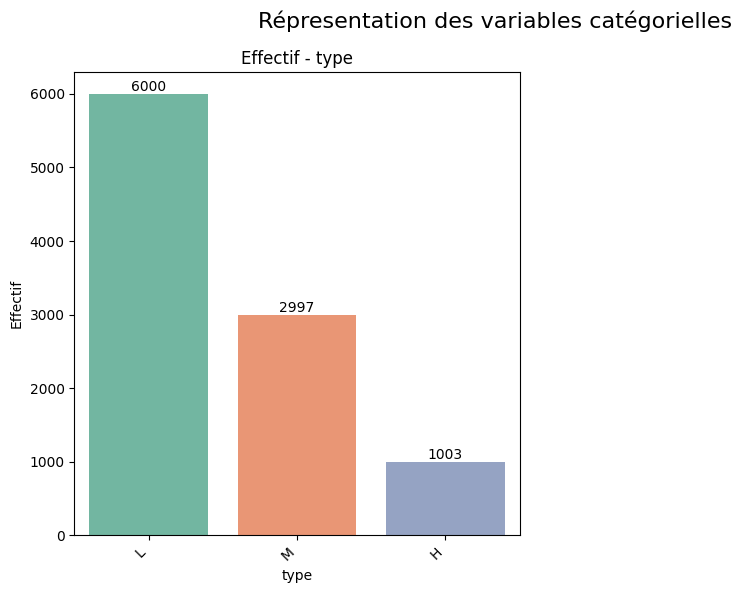

In [10]:
fig = plot_colonnes_categorielles(
    df,
    colonnes=categorical_columns,
    titre="Répresentation des variables catégorielles",
    palette="Set2",
)
plt.show()

## Statistiques descriptives - variables quantitatives

In [11]:
numeric_columns = [
    "air_temperature_k",
    "process_temperature_k",
    "rotational_speed_rpm",
    "torque_nm",
    "tool_wear_min",
]

In [12]:
# statistiques descriptives pour les variables quantitatives: moyenne, médiane, quartiles, min-max
df[numeric_columns].describe()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000
std,2.000259,1.483734,179.284096,9.968934,63.654147
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000


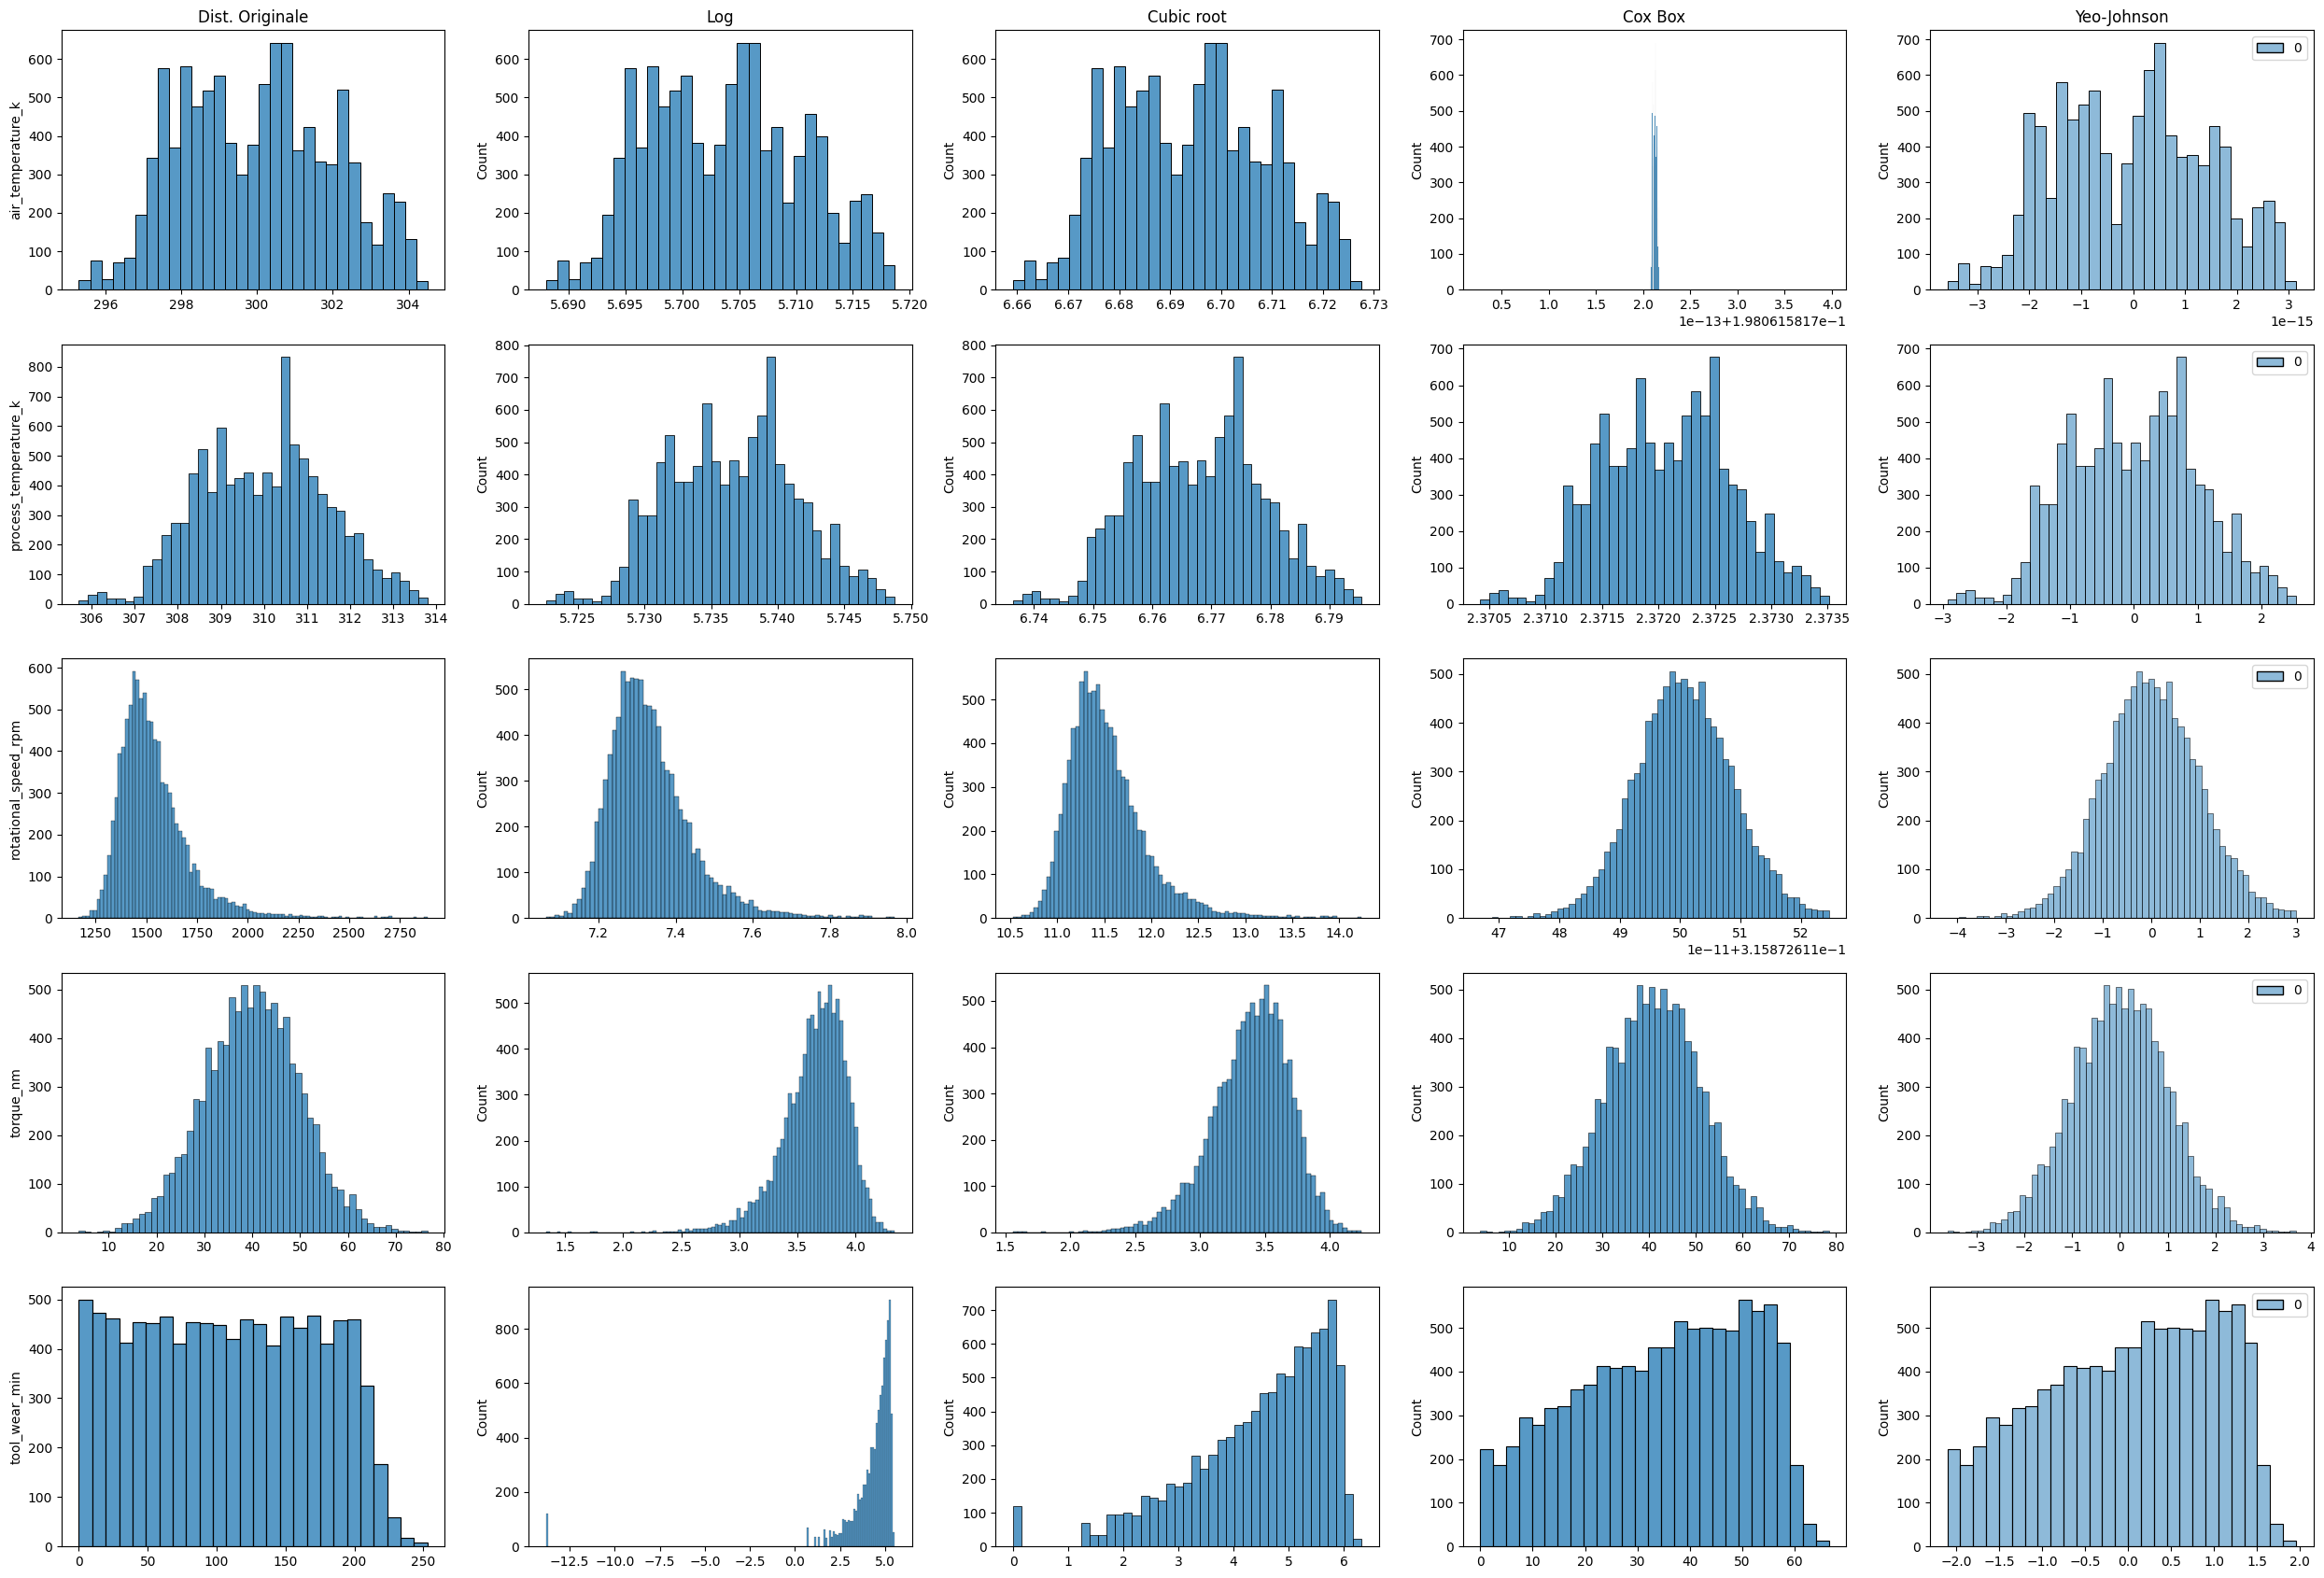

In [13]:
# Affichage de la distribution de chaque variable
# Transformations pour normalité

from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.stats import yeojohnson
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method="yeo-johnson")

# numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

df_num = df[numeric_columns]
_, axes = plt.subplots(df_num.shape[1], 5, figsize=(25, 17))
for col_index, col_name in enumerate(df_num):
    dist = df_num[col_name]
    axes[col_index, 0].set_ylabel(col_name)
    # normal dist
    sns.histplot(dist.to_numpy(), ax=axes[col_index, 0])
    # log
    new_dist = np.log(dist + 1e-6)
    sns.histplot(new_dist.to_numpy(), ax=axes[col_index, 1])
    # cubic root
    new_dist = np.cbrt(dist)
    sns.histplot(new_dist.to_numpy(), ax=axes[col_index, 2])
    # cox box
    new_dist, _ = yeojohnson(dist)
    sns.histplot(new_dist, ax=axes[col_index, 3])
    # yeo johnson
    new_dist = pt.fit_transform(dist.to_numpy().reshape(-1, 1))
    sns.histplot(new_dist, ax=axes[col_index, 4])

axes[0, 0].set_title("Dist. Originale")
axes[0, 1].set_title("Log")
axes[0, 2].set_title("Cubic root")
axes[0, 3].set_title("Cox Box")
axes[0, 4].set_title("Yeo-Johnson")
plt.tight_layout()
plt.show()

## Analyse doublons

In [14]:
# Doublons
exclude_columns = ["udi", "product_id", "twf", "hdf", "pwf", "osf", "rnf"]
df_unique_check = df.drop(columns=exclude_columns)
duplicates = df_unique_check[df_unique_check.duplicated()]
print("Total number of duplicate rows:", len(duplicates))

if len(duplicates) > 0:
    print("\nDuplicate Rows:")
    print(duplicates)

    original_duplicate_rows = df[
        df.drop(columns=exclude_columns).duplicated(keep=False)
    ]
    print("\nFull Original Duplicate Rows:")
    print(original_duplicate_rows)

    duplicate_counts = df_unique_check.value_counts()
    print("\nDuplicate Occurrence Counts:")
    print(duplicate_counts[duplicate_counts > 1])
else:
    print("No duplicate rows found.")

Total number of duplicate rows: 0
No duplicate rows found.


La colonne 'udi' ne va pas apporter de la valeur pour notre analyse.  
Les colonnes udi et product_id semblent etre uniques pour chaque observation

## Analyse valeurs manquantes

In [15]:
# Verifier des valeurs nulls
df.isnull().sum()

udi                      0
product_id               0
type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
machine_failure          0
twf                      0
hdf                      0
pwf                      0
osf                      0
rnf                      0
dtype: int64

Pas de valeurs manquants

## Analyse valeurs aberrantes (outliers)

Il y a 418 outliers pour rotational_speed_rpm. Ca represente 4.18% par rapport au total 
Il y a 69 outliers pour torque_nm. Ca represente 0.69% par rapport au total 


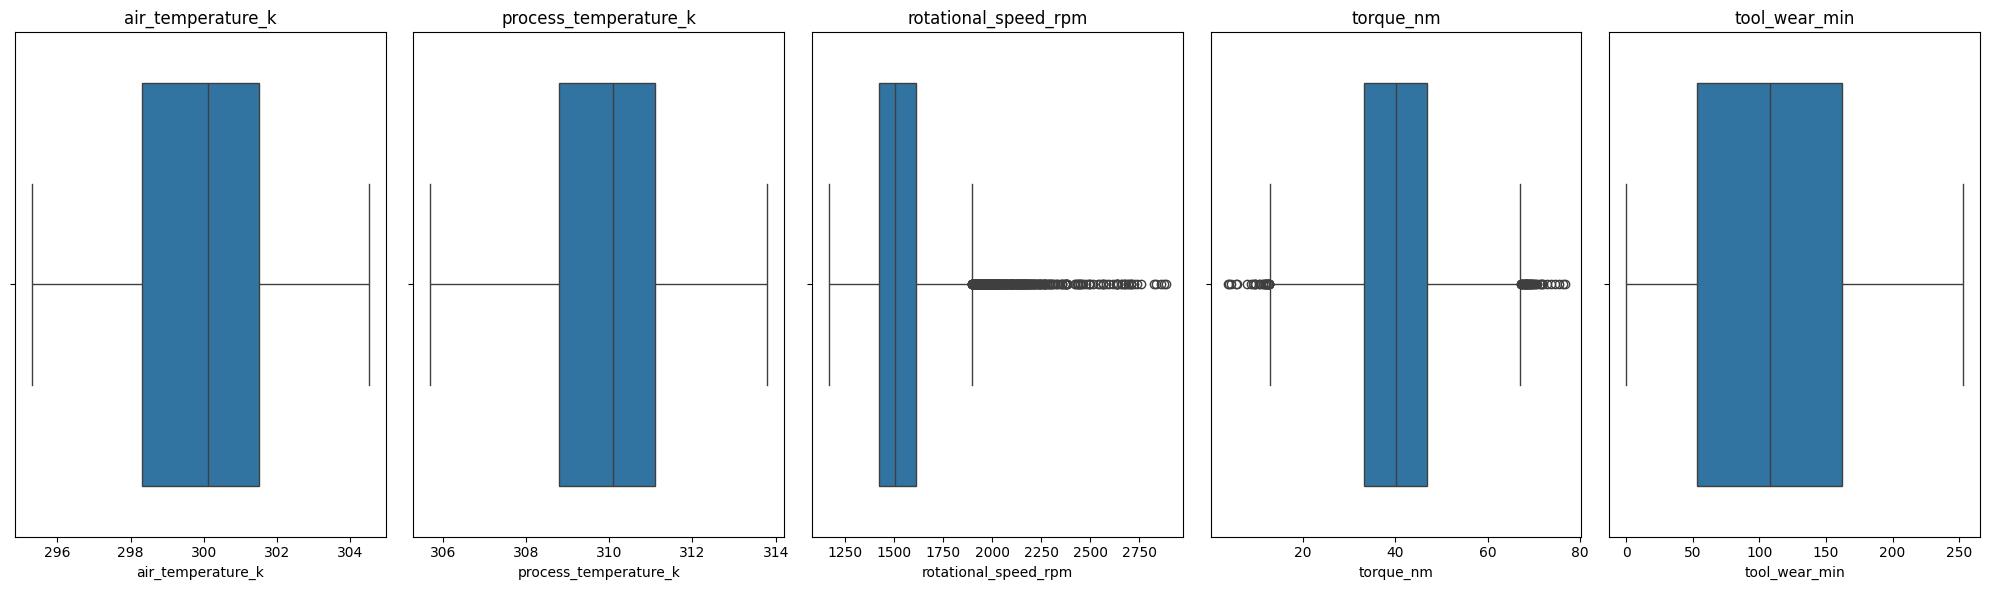

In [16]:
def detect_outliers(df, column):
    # Q1 (25th percentile) Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identifier outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers


columns_to_check = [
    "air_temperature_k",
    "process_temperature_k",
    "rotational_speed_rpm",
    "torque_nm",
    "tool_wear_min",
]

# boxplot
plt.figure(figsize=(20, 6))
for idx, column in enumerate(columns_to_check, start=1):
    plt.subplot(1, len(columns_to_check), idx)
    sns.boxplot(data=df, x=column)
    plt.title(f"{column}")

    outliers = detect_outliers(df, column)
    if not outliers.empty:
        print(
            f"Il y a {outliers[column].size} outliers pour {column}. Ca represente {outliers[column].size * 100/ len(df):.2f}% par rapport au total "
        )

# Show the plot
plt.tight_layout()
plt.show()

## Analyse de correlation entre variables

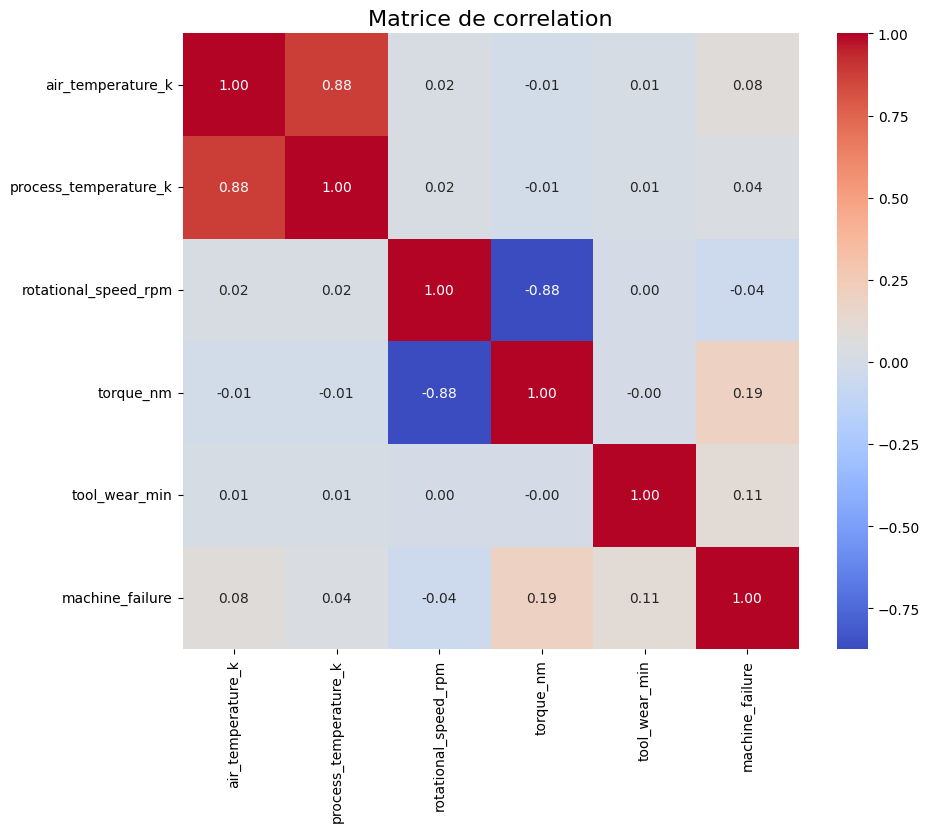

In [17]:
# Compute the correlation matrix for numeric columns
corr_columns = [
    "air_temperature_k",
    "process_temperature_k",
    "rotational_speed_rpm",
    "torque_nm",
    "tool_wear_min",
    "machine_failure",
]

df_num = df[corr_columns]
correlation_matrix = df_num.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, square=True
)

# Add a title
plt.title("Matrice de correlation", fontsize=16)

# Show the plot
plt.show()

## Analyse de variables avec pairplot

<Figure size 1000x1000 with 0 Axes>

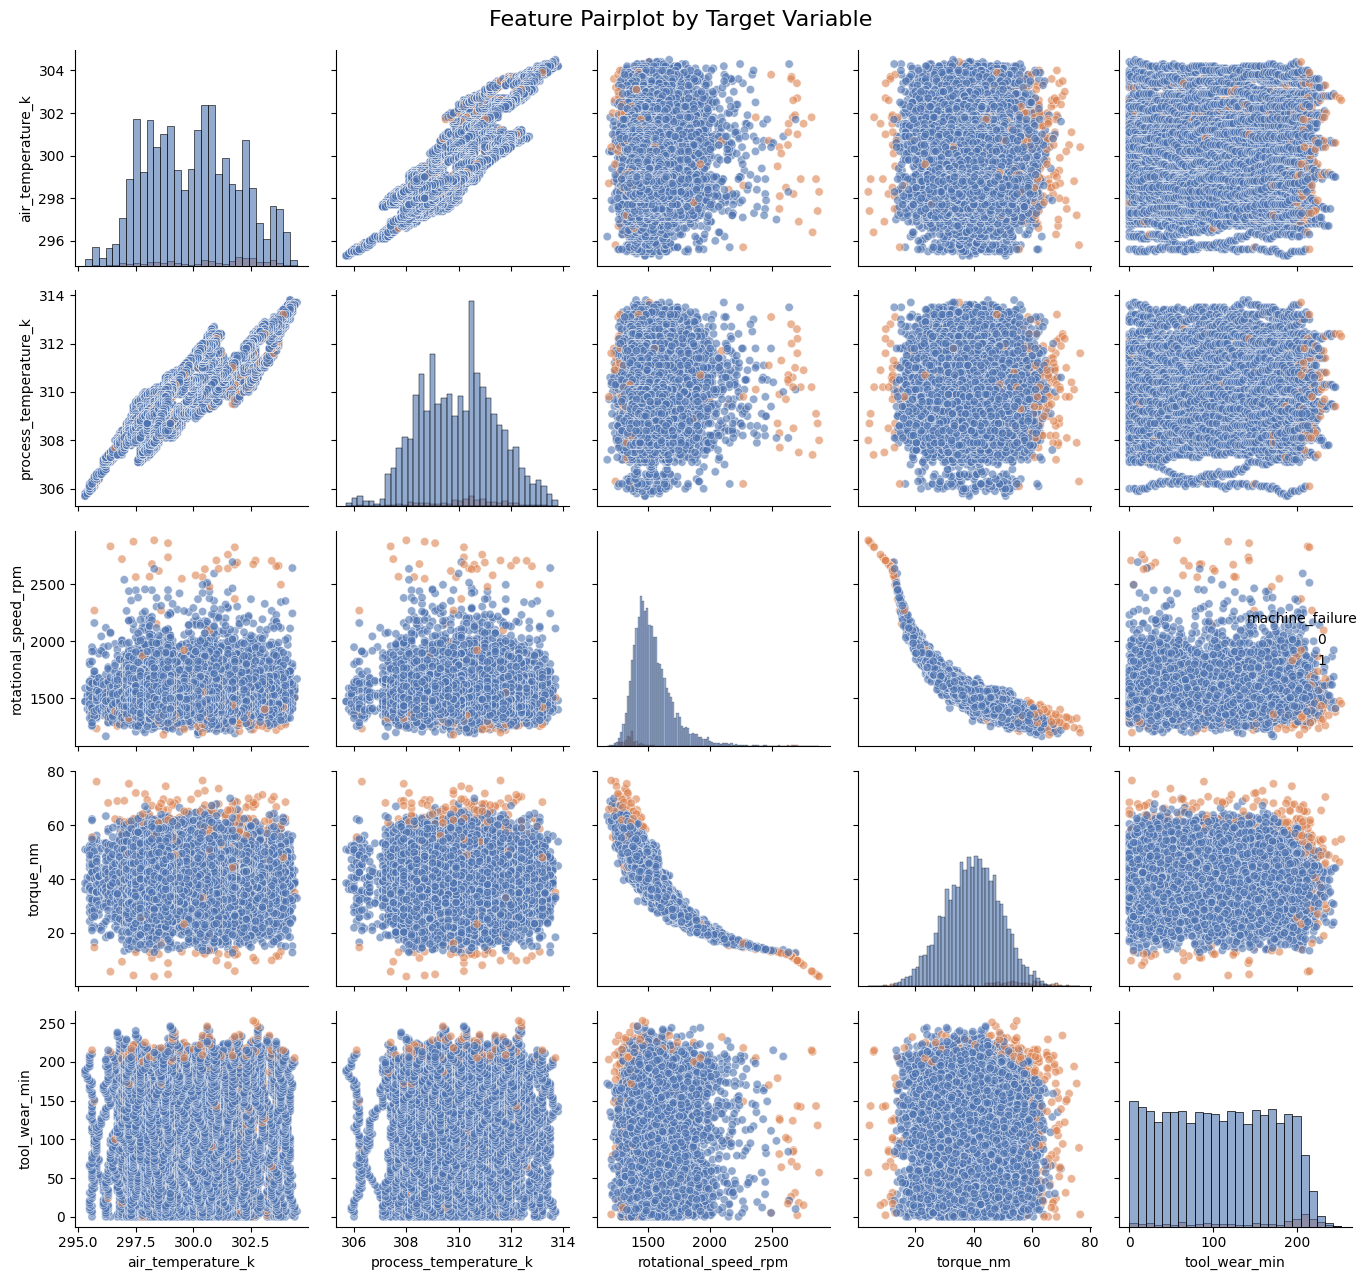

In [18]:
plt.figure(figsize=(10, 10))
pairplot = sns.pairplot(
    data=df_num,
    # vars=[col for col in df.columns if col != 'target'],  # Exclude target from features
    hue="machine_failure",  # Color by target variable
    palette="deep",  # Color palette to use
    diag_kind="hist",  # Show histograms on diagonal
    plot_kws={"alpha": 0.6},  # Set transparency for better visibility
    diag_kws={"alpha": 0.6},
)

# Adjust the layout
plt.tight_layout()
pairplot.figure.suptitle("Feature Pairplot by Target Variable", y=1.02, size=16)
plt.show()

## Analyse de la variable cible

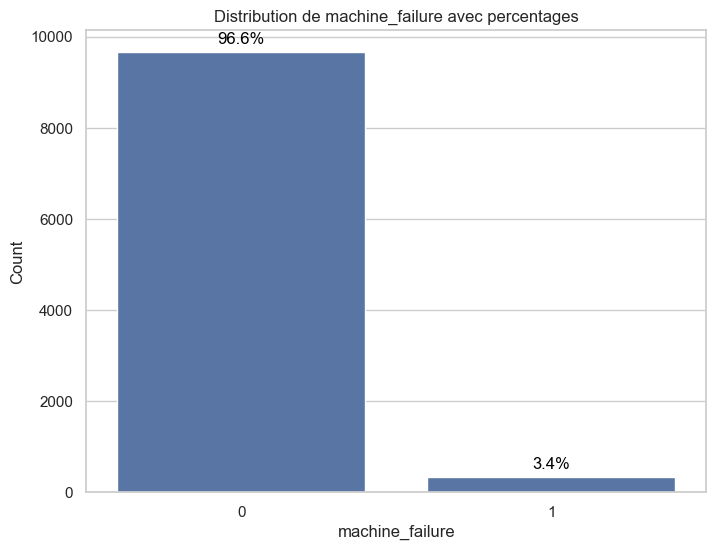

In [19]:
target_column = "machine_failure"

# Create a countplot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x=target_column)

# Calculate the percentages
total = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = 100 * height / total
    ax.annotate(
        f"{percentage:.1f}%",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="center",
        fontsize=12,
        color="black",
        xytext=(0, 9),
        textcoords="offset points",
    )

plt.title(f"Distribution de {target_column} avec percentages")
plt.xlabel(target_column)
plt.ylabel("Count")


plt.show()

In [20]:
target_distribution = df["machine_failure"].value_counts(normalize=True)
print(f"Distribution de la variable cible {target_distribution}")

Distribution de la variable cible machine_failure
0    0.9661
1    0.0339
Name: proportion, dtype: float64



On trouve que pour le dataset, 96.61% de cas sont pas de cas de panne de la machine.  
Le reste (33.9%) sont de cas de panne.

La classe 1 (panne) est significativement sous-représentée par rapport à la classe 0.  
Il faudra definir comment traiter l'ensemble des données déséquilibrés  

<font color='blue'>
Voici quelques options :

1. Rééchantillonnage (Resampling)  
Suréchantillonnage de la classe minoritaire : Augmenter le nombre d'échantillons de la classe minoritaire, soit en dupliquant les échantillons existants, soit en générant des échantillons synthétiques.  
Sous-échantillonnage de la classe majoritaire : Réduire le nombre d'échantillons de la classe majoritaire pour équilibrer la distribution des classes.  

2. Ajustements algorithmiques  
Utiliser des algorithmes qui gèrent les données déséquilibrées, tels que :  
Pondération des classes : Assigner des poids différents aux classes pour que le modèle prête plus d'attention à la classe minoritaire.  
Méthodes d'ensembles : Utiliser des méthodes comme Random Forest ou XGBoost, qui combinent plusieurs modèles pour améliorer la prédiction de la classe minoritaire.  

3. Mesures d'évaluation  
Plutôt que de se concentrer sur la précision (accuracy), il est recommandé d'utiliser des mesures qui prennent en compte les déséquilibres de classes :  
Précision, rappel (recall), F1-score : Ces mesures sont plus informatives lorsque les classes sont déséquilibrées.  
ROC-AUC et AUC de précision-rappel (Precision-Recall AUC) : Ces courbes permettent d’évaluer la capacité du modèle à différencier les classes, en particulier lorsqu'il y a un déséquilibre marqué.  

4. Techniques avancées  
SMOTE (Synthetic Minority Over-sampling Technique) : Génère des exemples synthétiques pour la classe minoritaire.  
Apprentissage sensible au coût : Augmenter la pénalité des erreurs de classification dans la classe minoritaire.  
Détection d’anomalies : Utilisée lorsque la classe minoritaire est extrêmement rare, cette approche modélise le problème comme une détection d’anomalies.
</font>

Apres regarder la matrice de correlation on peut affirmer que:  
- 'air_temperature_k' et 'process_temperature_k' ont une forte correlation
- 'rotational_speed_rpm' et 'torque_nm' ont une forte correlation inverse  


## AFDM

AFDM (Analyse factorielle de données mixtes)  
L'ensemble d'observations inclut de variables quantitatives (numériques) et qualitatives (catégorielles)

In [21]:
print("Colonnes dans dataset original")
print(df.columns)

Colonnes dans dataset original
Index(['udi', 'product_id', 'type', 'air_temperature_k',
       'process_temperature_k', 'rotational_speed_rpm', 'torque_nm',
       'tool_wear_min', 'machine_failure', 'twf', 'hdf', 'pwf', 'osf', 'rnf'],
      dtype='object')


On pourrait donc enlever les colonnes suivantes:
- 'udi','product_id': parce que la valeur c'est unique pour chaque observation et ne donne pas de l'information pour la construction du modele
- 'process_temperature_k': forte correlation avec 'air_temperature_k'
- 'torque_nm': forte_correlation avec 'rotational_speed_rpm'
- 'machine_failure' répresente la variable cible
- 'twf', 'hdf', 'pwf', 'osf', 'rnf': parce qu'ils représentent le type de panne 

In [22]:
def encode_categorical_variables(df, columns=None, drop_first=True):
    """
    Encode categorical variables using one-hot encoding and remove the first/last column

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    columns : list, optional
        List of categorical columns to encode.
        If None, selects all object or category dtype columns
    drop_first : bool, default True
        Whether to drop the first dummy column

    Returns:
    --------
    pandas.DataFrame
        DataFrame with encoded categorical variables
    """
    # If no columns specified, select all categorical columns
    if columns is None:
        columns = df.select_dtypes(include=["object", "category"]).columns

    # Create a copy of the DataFrame to avoid modifying the original
    df_encoded = df.copy()

    # Encode specified columns
    for column in columns:
        # Create dummy variables
        dummies = pd.get_dummies(
            df_encoded[column], prefix=column, drop_first=drop_first
        ).astype(int)

        # Remove original categorical column
        df_encoded = df_encoded.drop(column, axis=1)

        # Add dummy columns to the DataFrame
        df_encoded = pd.concat([df_encoded, dummies], axis=1)

    return df_encoded

In [23]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler


def prepare_dataset_for_famd(
    df, numeric_columns, numeric_scaler="standard", categorical_columns=None
):
    """
    Prepare a dataset for Factor Analysis of Mixed Data (FAMD)

    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe to be prepared
    numeric_columns : list
        List of column names containing numeric variables
    numeric_scaler : str, optional (default='standard')
        Scaling method for numeric columns
        Options: 'standard', 'robust', 'minmax'
    categorical_columns : list, optional
        List of column names containing categorical variables

    Returns:
    --------
    pandas.DataFrame
        Prepared dataframe with transformed columns
    """
    # Create a copy of the dataframe to avoid modifying the original
    prepared_df = df.copy()

    # Handle numeric columns scaling
    if numeric_columns:
        # Select scaling method
        if numeric_scaler.lower() == "robust":
            scaler = RobustScaler()
        elif numeric_scaler.lower() == "minmax":
            scaler = MinMaxScaler()
        else:
            scaler = StandardScaler()

        # Apply scaling to numeric columns
        prepared_df[numeric_columns] = scaler.fit_transform(
            prepared_df[numeric_columns]
        )

    # Handle categorical columns
    if categorical_columns:
        for col in categorical_columns:
            # Calculate the square root of (column sum / number of rows)
            col_sum = prepared_df[col].sum()
            normalizer = np.sqrt(col_sum / len(prepared_df))

            # Transform categorical column
            prepared_df[col] = prepared_df[col] / normalizer

    return prepared_df

In [24]:
from sklearn.decomposition import PCA


def get_optimal_pca(
    df, max_components=None, variance_threshold=0.80, plot=True, scree_plot=True
):
    """
    Determine the optimal number of Principal Components for a given dataset

    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe with numerical features. Already scaled
    max_components : int, optional
        Maximum number of components to consider
        (defaults to min(number of features, number of samples))
    variance_threshold : float, optional (default=0.80)
        Cumulative explained variance ratio threshold
    plot : bool, optional (default=True)
        Whether to create a cumulative explained variance plot
    scree_plot : bool, optional (default=True)
        Whether to create a scree plot

    Returns:
    --------
    dict containing:
    - optimal_components: Number of components meeting variance threshold
    - explained_variance_ratio: Explained variance ratio for each component
    - cumulative_explained_variance: Cumulative explained variance
    - pca: Fitted PCA object
    - output_df : df transformed using PCA
    """

    # Determine max components if not specified
    if max_components is None:
        max_components = min(df.shape[0], df.shape[1])

    # Perform PCA
    pca = PCA(n_components=max_components)
    # pca.fit(df)
    output_df = pca.fit_transform(df)

    # Calculate cumulative explained variance
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

    # Determine optimal number of components
    optimal_components = (
        np.argmax(cumulative_explained_variance >= variance_threshold) + 1
    )

    # Plotting
    if plot or scree_plot:
        plt.figure(figsize=(12, 4))

        if plot:
            plt.subplot(1, 2, 1)
            plt.plot(
                range(1, len(cumulative_explained_variance) + 1),
                cumulative_explained_variance,
                "bo-",
            )
            plt.title("Cumulative Explained Variance")
            plt.xlabel("Number of Components")
            plt.ylabel("Cumulative Explained Variance Ratio")
            plt.axhline(y=variance_threshold, color="r", linestyle="--")
            plt.axvline(x=optimal_components, color="g", linestyle="--")

        if scree_plot:
            plt.subplot(1, 2 if plot else 1, 2)
            plt.bar(
                range(1, len(pca.explained_variance_ratio_) + 1),
                pca.explained_variance_ratio_,
            )
            plt.title("Scree Plot")
            plt.xlabel("Principal Component")
            plt.ylabel("Explained Variance Ratio")

        plt.tight_layout()
        plt.show()

    return {
        "optimal_components": optimal_components,
        "explained_variance_ratio": pca.explained_variance_ratio_,
        "cumulative_explained_variance": cumulative_explained_variance,
        "pca": pca,
        "output_df": pd.DataFrame(
            output_df, columns=[f"PC{i+1}" for i in range(output_df.shape[1])]
        ),
    }

In [25]:
# Voici comment on pourrait preparer le dataset a la fin de l'AED

# 1. Suprimer les colonnes qui ne sont pas nécessaires pour l'analyse
afdm_columns = ["type", "air_temperature_k", "rotational_speed_rpm", "tool_wear_min"]
df_afdm = df[afdm_columns]

# 2. Transformer les colonnes catégorielles a colonnes numériques... colonne type
categorical_columns = ["type"]
df_afdm = encode_categorical_variables(
    df_afdm, columns=categorical_columns, drop_first=True
)

# 3. Standarization avec AFDM
numeric_columns = ["air_temperature_k", "rotational_speed_rpm", "tool_wear_min"]
categorical_columns = ["type_L", "type_M"]

df_afdm_final = prepare_dataset_for_famd(
    df_afdm,
    numeric_columns=numeric_columns,
    numeric_scaler="standard",
    categorical_columns=categorical_columns,
)
display(df_afdm_final.sample(10))

,air_temperature_k,rotational_speed_rpm,tool_wear_min,type_L,type_M
7874,0.347507,0.051451,-0.784764,1.290994,0.000000
2902,0.297511,0.012405,-0.046362,0.000000,1.826655
616,-0.952389,0.821218,-0.753343,0.000000,0.000000
8028,0.297511,-0.210716,1.854630,1.290994,0.000000
4119,1.047452,-1.192447,1.571838,1.290994,0.000000
2636,-0.052461,-1.588486,0.252141,1.290994,0.000000
7204,-0.102457,-0.071265,-0.360576,1.290994,0.000000
1214,-1.602338,0.865842,0.110745,0.000000,1.826655
2277,-0.352437,-0.729472,-0.407708,0.000000,0.000000
9190,-1.002385,-0.556553,-1.161821,0.000000,1.826655


Performing PCA Analysis:


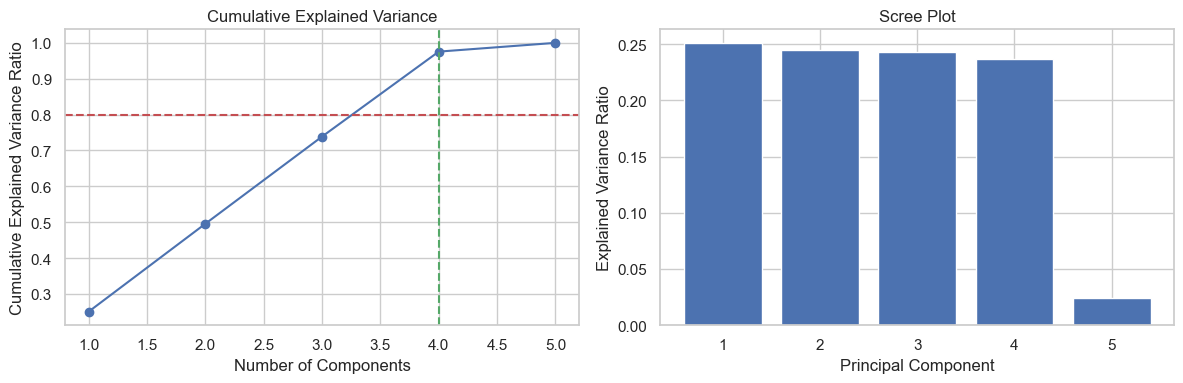


Optimal Number of Components: 4

Explained Variance Ratio:
PC1: 0.2505
PC2: 0.2451
PC3: 0.2431
PC4: 0.2369
PC5: 0.0244

Cumulative Explained Variance:
1 Components: 0.2505
2 Components: 0.4956
3 Components: 0.7387
4 Components: 0.9756
5 Components: 1.0000


In [26]:
print("Performing PCA Analysis:")
pca_results = get_optimal_pca(df_afdm_final)

# Print out key results
print(f"\nOptimal Number of Components: {pca_results['optimal_components']}")

print("\nExplained Variance Ratio:")
for i, ratio in enumerate(pca_results["explained_variance_ratio"], 1):
    print(f"PC{i}: {ratio:.4f}")

print("\nCumulative Explained Variance:")
cumulative = pca_results["cumulative_explained_variance"]
for i, var in enumerate(cumulative, 1):
    print(f"{i} Components: {var:.4f}")

In [27]:
def plot_pca_components(df):
    """
    Create scatterplots for all combinations of PCA components in the dataframe.

    Parameters:
    df (pandas.DataFrame): The dataframe containing the PCA components.
    """
    pca_cols = [col for col in df.columns if col.startswith("PC")]
    num_cols = len(pca_cols)

    for i in range(num_cols):
        for j in range(i + 1, num_cols):
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=pca_cols[i], y=pca_cols[j], data=df)
            plt.xlabel(pca_cols[i])
            plt.ylabel(pca_cols[j])
            plt.title(f"Scatterplot of {pca_cols[i]} vs {pca_cols[j]}")
            plt.show()

In [28]:
def plot_pca_scatterplots(df, pca_cols=None, target_col="target"):
    """
    Create a scatterplot matrix of PCA components, colored by the target variable.

    Parameters:
    df (pandas.DataFrame): The dataframe containing the PCA components and the target variable.
    pca_cols (list): The names of the PCA component columns.
    target_col (str): The name of the target variable column.
    """
    if pca_cols is None:
        pca_cols = [col for col in df.columns if col.startswith("PC")]
    num_components = len(pca_cols)

    for i in range(num_components):
        for j in range(i + 1, num_components):
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=pca_cols[i], y=pca_cols[j], data=df, hue=target_col)
            plt.xlabel(pca_cols[i])
            plt.ylabel(pca_cols[j])
            plt.title(f"Scatterplot of {pca_cols[i]} vs {pca_cols[j]}")
            plt.show()

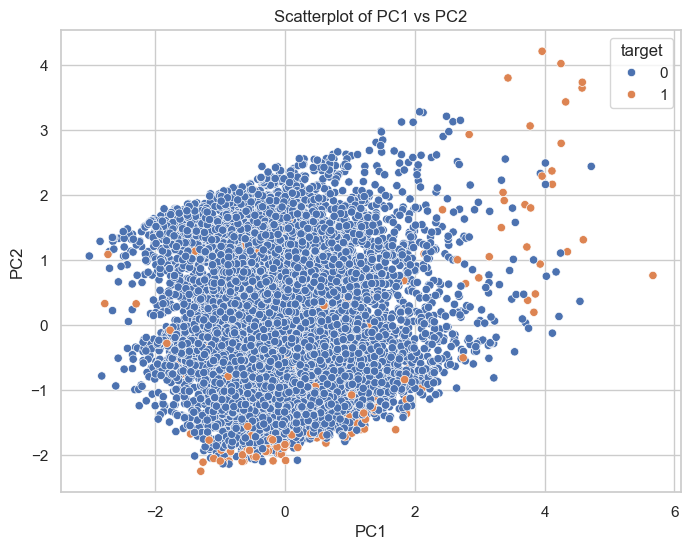

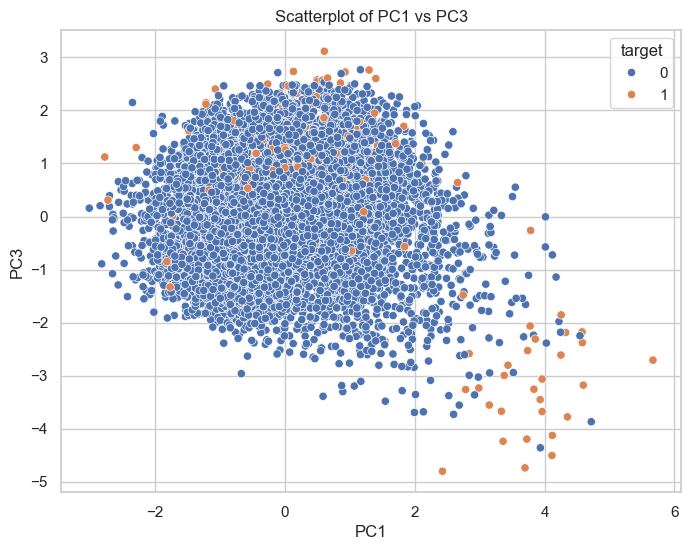

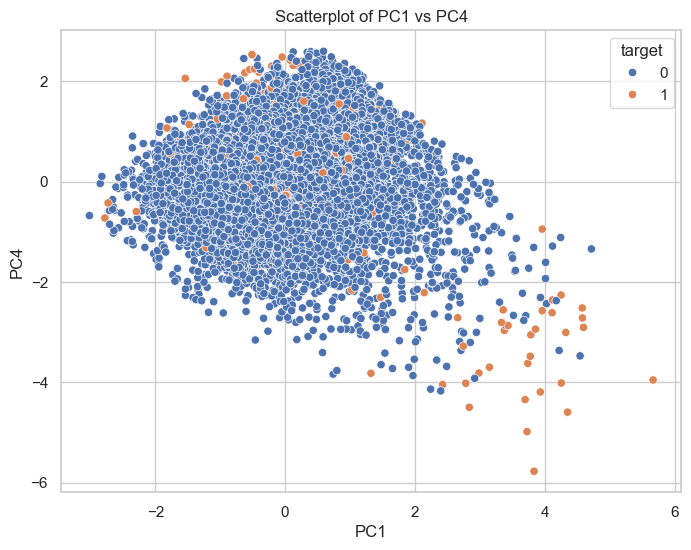

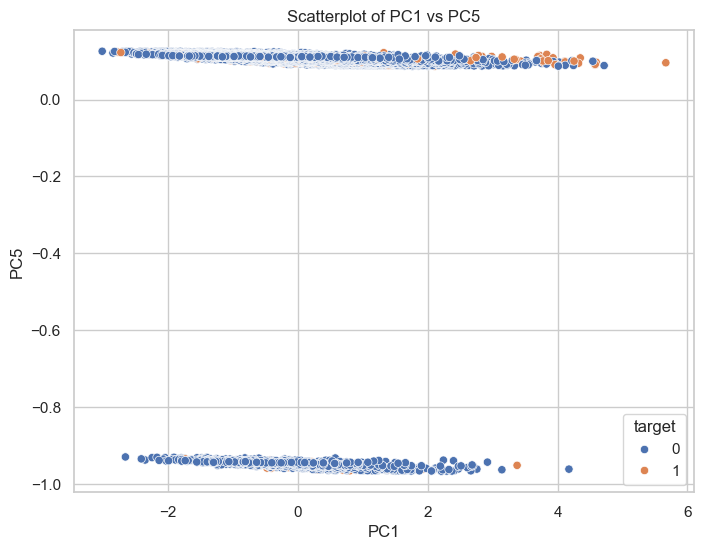

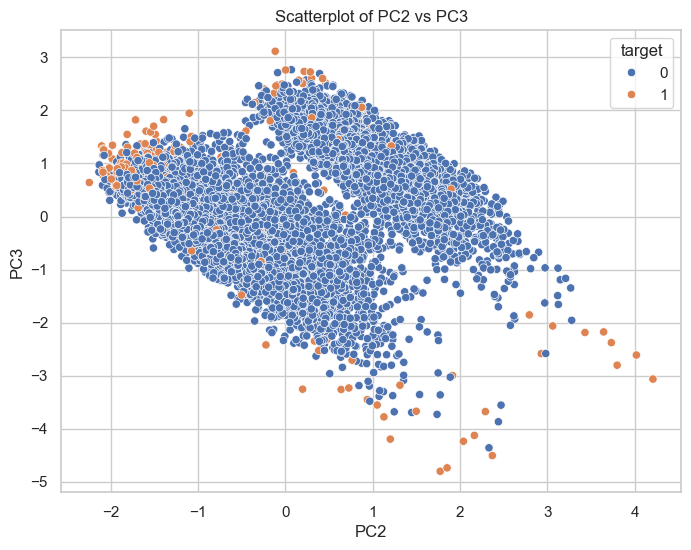

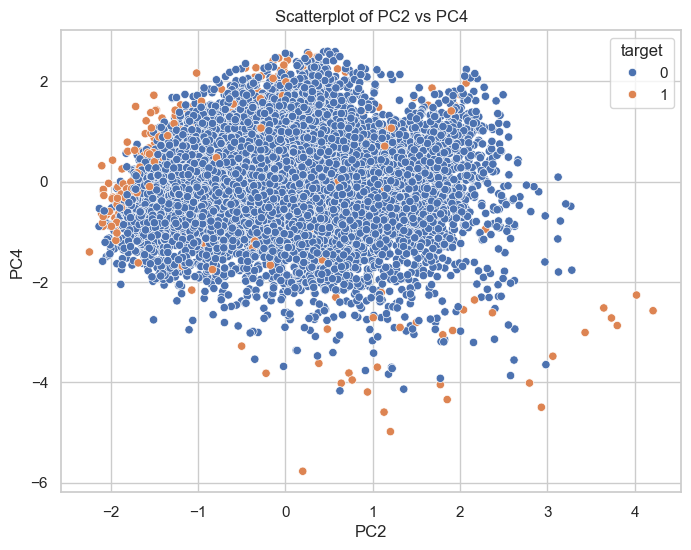

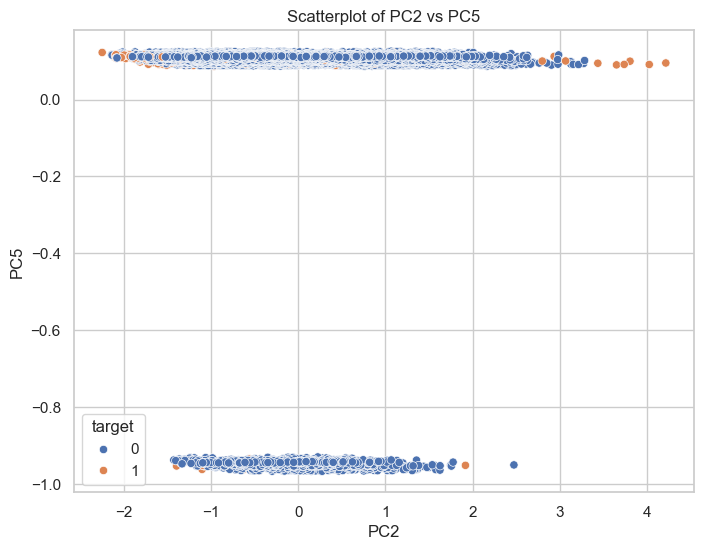

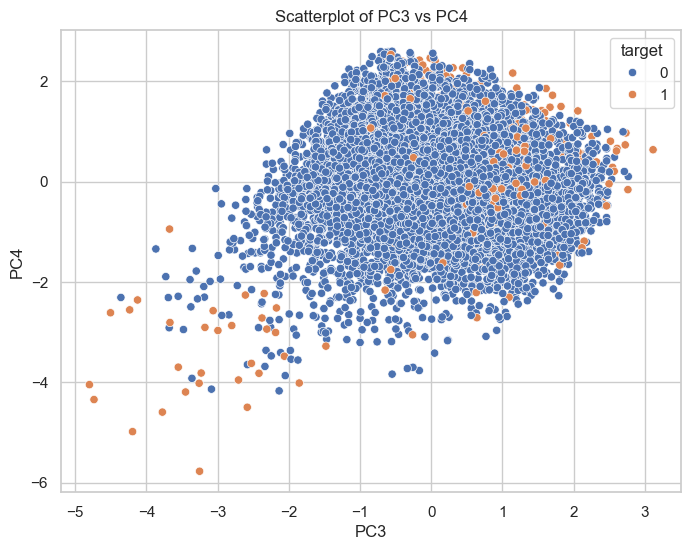

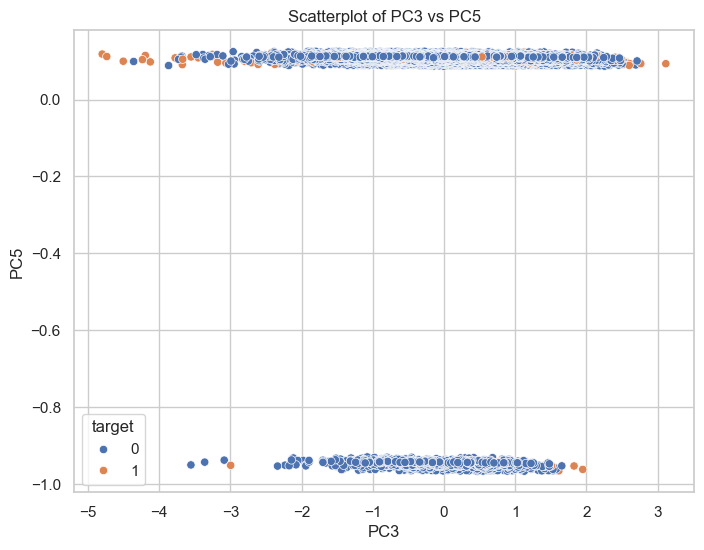

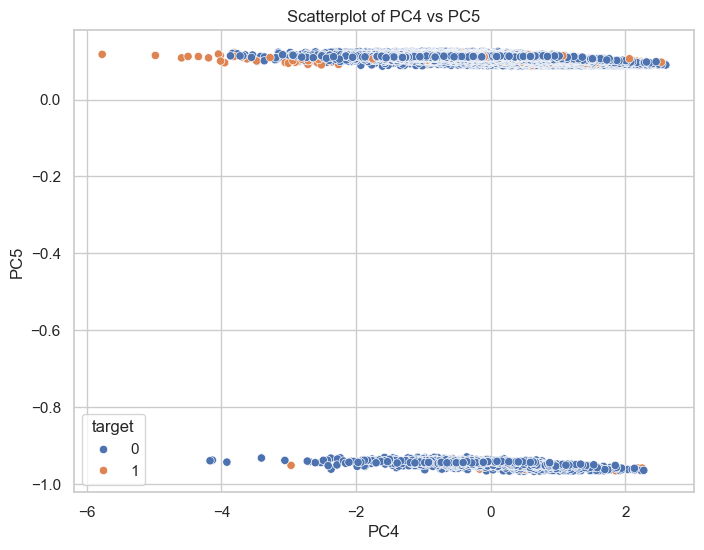

In [29]:
df_pca = pca_results["output_df"]
df_pca["target"] = df["machine_failure"]

plot_pca_scatterplots(
    df_pca, [col for col in df_pca.columns if col.startswith("PC")], "target"
)